# Libraries

In [64]:
# Import the warnings module to handle warning messages
import warnings

# Suppress all warning messages
warnings.filterwarnings('ignore')

In [67]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import os  # For interacting with the operating system
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For advanced data visualization
import sys  # For system-specific parameters and functions
import random  # For generating random numbers

# Import TimeSeries class and metrics from Darts for time series analysis
from darts import TimeSeries
from darts.metrics import mae, rmse  # Metrics for evaluating model performance

# Import anomaly detection models and scorers from Darts
from darts.ad import ForecastingAnomalyModel, KMeansScorer, NormScorer
from darts.ad.detectors import QuantileDetector

# Import the Temporal Convolutional Network model from Darts
from darts.models import TCNModel

# Import PyTorch Lightning components for training and callbacks
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, EarlyStopping

# Import utility functions from Darts for statistical analysis
from darts.utils.statistics import check_seasonality

# Import additional metrics for model evaluation
from darts.metrics import mse
from sklearn.metrics import roc_auc_score, average_precision_score  # Metrics for classification performance
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.preprocessing import RobustScaler  # For robust scaling of features

# Import optimizer from PyTorch
from torch.optim import Adam  # For optimization during model training

# Loading Data

In [68]:
# Load training data from the specified file into a DataFrame
# The file is delimited by whitespace characters and has no header row
df_1 = pd.read_csv("D:/internship project/ECG5000_TRAIN.txt", delimiter='\s+', header=None)

# Load test data from the specified file into a DataFrame
# The file is delimited by whitespace characters and has no header row
df_2 = pd.read_csv("D:/internship project/ECG5000_TEST.txt", delimiter='\s+', header=None)

In [69]:
# Combine the training and test DataFrames into a single DataFrame
# Ignore the index to reset it in the combined DataFrame
df = pd.concat([df_1, df_2], ignore_index=True)

# Save the combined DataFrame to a new CSV file
# Do not include row indices or column headers in the output file
df.to_csv('D:/internship project/Combined_data.csv', index=False, header=False)

In [70]:
# Display the first few rows of the DataFrame to inspect its contents
df.head()

0         1         2         3         4         5         6         7    \
0  1.0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1  1.0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2  1.0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  1.0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  1.0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9    ...       131       132       133       134       135  \
0 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  ...  0.560327  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580  ...  1.284825  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884  ...  0.491173  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450  ...  0.966606  1.148884  0.958434  1.059025  1.371682   

        136       137       138       139       140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 141 columns]

In [71]:
# Display information about the DataFrame, including the number of entries, column names, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [72]:
# Generate descriptive statistics for the DataFrame, including count, mean, standard deviation, min, max, and percentiles for each column
df.describe()

0            1            2            3            4    \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      1.527400    -0.262476    -1.649511    -2.492211    -3.119443   
std       0.760372     1.152369     1.445493     1.386409     1.302802   
min       1.000000    -6.729499    -7.090374    -5.132459    -5.363241   
25%       1.000000    -1.004511    -2.701576    -3.668096    -4.227247   
50%       1.000000    -0.297541    -1.661892    -2.585677    -3.387934   
75%       2.000000     0.500061    -0.677290    -1.513964    -2.235369   
max       5.000000     4.966414     3.479689     2.660597     1.899798   

               5            6            7            8            9    ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean     -3.167438    -2.866308    -2.273126    -1.798127    -1.410124  ...   
std       1.104382     0.906133     0.731627     0.623100     0.637149  ...   
min      -5.375715    -5.330194    -4.782240    -4.311288    -4.071361  ...   
25%      -4.007470    -3.480479    -2.779941    -2.165851    -1.774124  ...   
50%      -3.468718    -2.947061    -2.285578    -1.750157    -1.422570  ...   
75%      -2.530967    -2.398813    -1.823494    -1.484923    -1.063708  ...   
max       2.147015     1.614375     1.868728     1.804251     1.683730  ...   

               131          132          133          134          135  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.146319     0.070973    -0.062914    -0.276206    -0.507667   
std       1.171299     1.404842     1.646585     1.895134     2.059758   
min      -3.971715    -4.167040    -4.557576    -4.530488    -4.563270   
25%      -0.655753    -1.089300    -1.588885    -2.147449    -2.731550   
50%       0.473642     0.658318     0.717808     0.604747     0.334857   
75%       1.062134     1.169420     1.238687     1.264471     1.234433   
max       2.960969     3.007606     2.854680     2.912394     2.937685   

               136          137          138          139          140  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean     -0.761043    -0.834741    -0.642263    -0.487242    -0.706008  
std       2.086218     2.056220     1.859296     1.830987     1.414465  
min      -5.150100    -4.880460    -5.496107    -5.880890    -6.092227  
25%      -3.030509    -2.868331    -2.153513    -1.657771    -1.596692  
50%      -0.030767    -0.195151    -0.194423    -0.160262    -0.565588  
75%       1.034584     0.945237     0.951681     1.002692     0.272012  
max       3.351437     3.432519     3.579448     4.425976     7.402103  

[8 rows x 141 columns]

In [73]:
# Check for missing values in each column and display the count of missing values
df.isnull().sum()

# Remove rows with any missing values from the DataFrame
# The `inplace=True` argument ensures the changes are applied directly to the original DataFrame
df.dropna(inplace=True)

# Extracting Normal, Abnormal Data

In [74]:
# Separate the DataFrame into normal and abnormal data based on the value in the first column
# Normal data: rows where the first column value is 1
normal_data = df.loc[df[0] == 1]

# Abnormal data: rows where the first column value is not 1
abnormal_data = df.loc[df[0] != 1]

# Save the normal data to a CSV file
# Do not include row indices in the output file
normal_data.to_csv('D:/internship project/normal data.csv', index=False)

# Save the abnormal data to a CSV file
# Do not include row indices in the output file
abnormal_data.to_csv('D:/internship project/abnormal data.csv', index=False)

# Plots

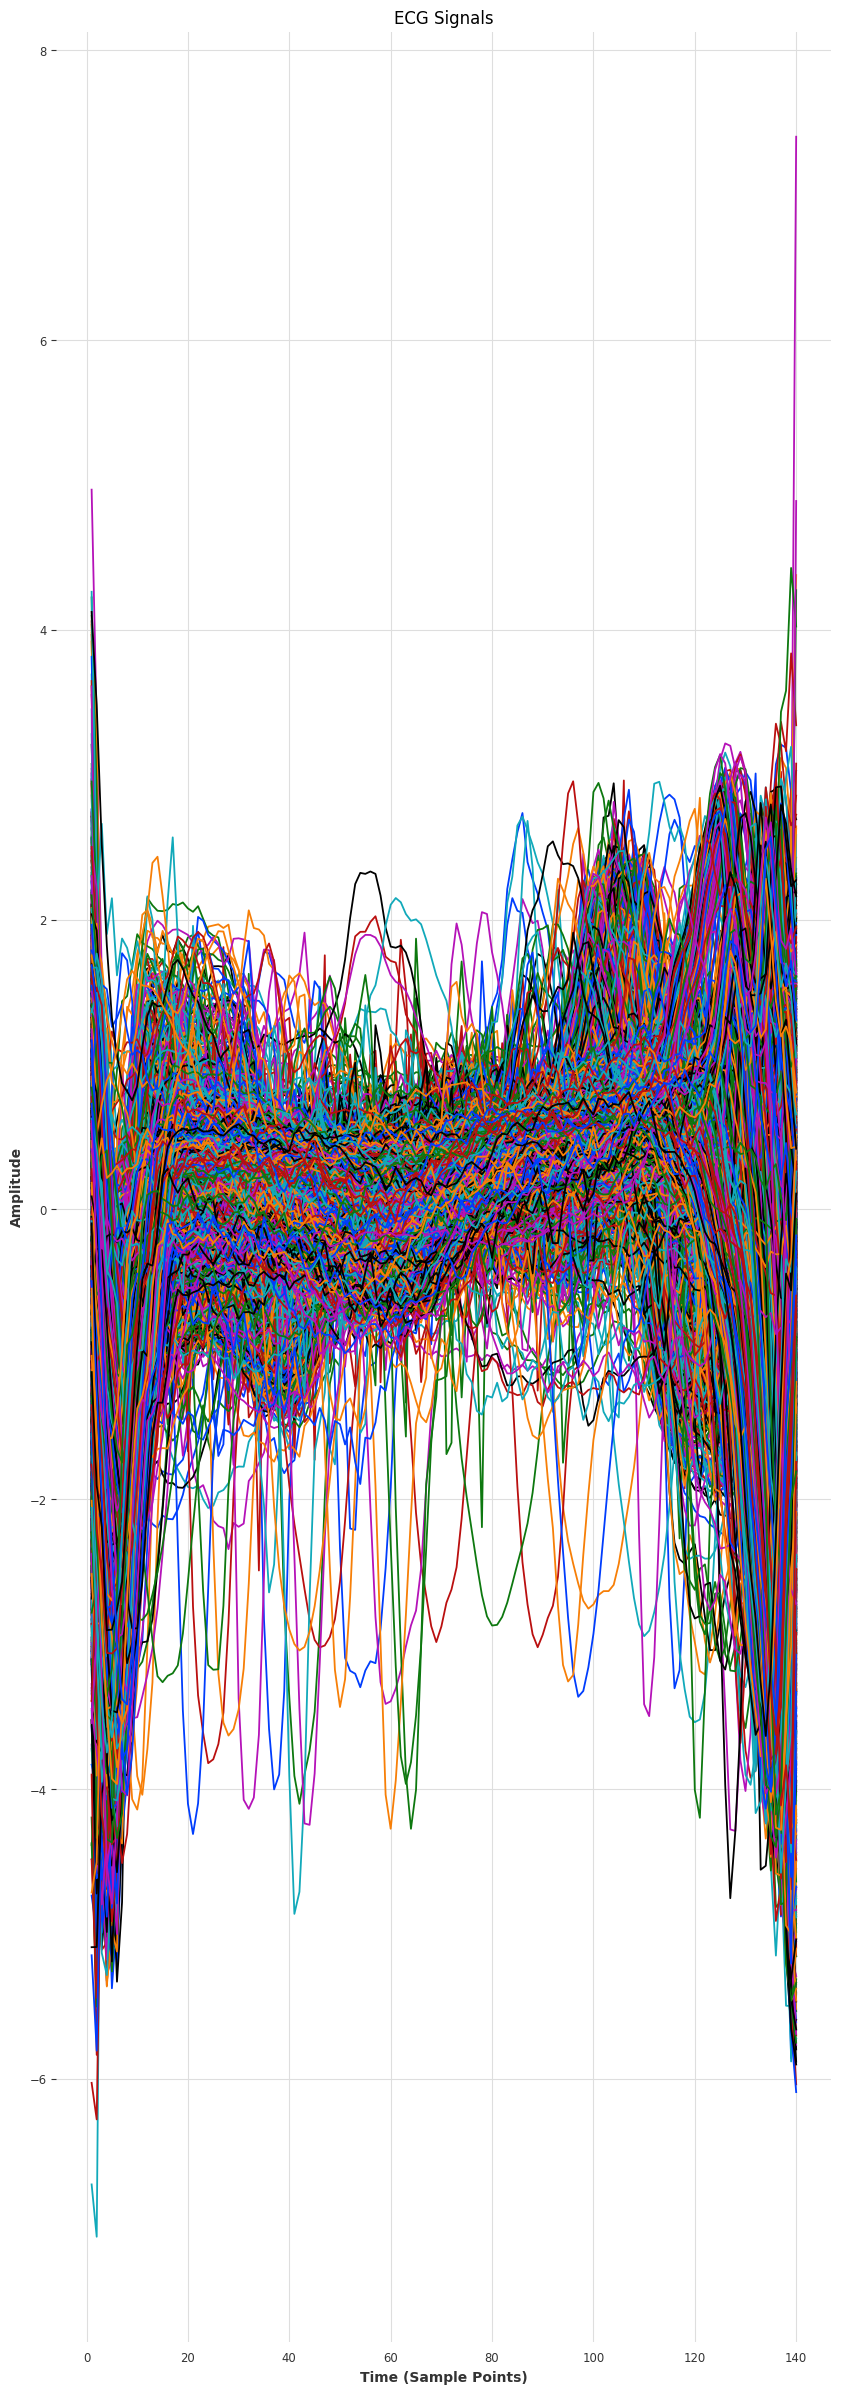

In [77]:
# Extract ECG signal data from the DataFrame, excluding the first column (assumed to be labels)
ecg_signals = df.iloc[:, 1:]

# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 30))

# Iterate over each row in the ECG signals DataFrame and plot the signal
# The label for each plot is based on the row index (signal number)
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')

# Label the x-axis as 'Time (Sample Points)'
plt.xlabel('Time (Sample Points)')

# Label the y-axis as 'Amplitude'
plt.ylabel('Amplitude')

# Set the title of the plot to 'ECG Signals'
plt.title('ECG Signals')

# Display the plot
plt.show()

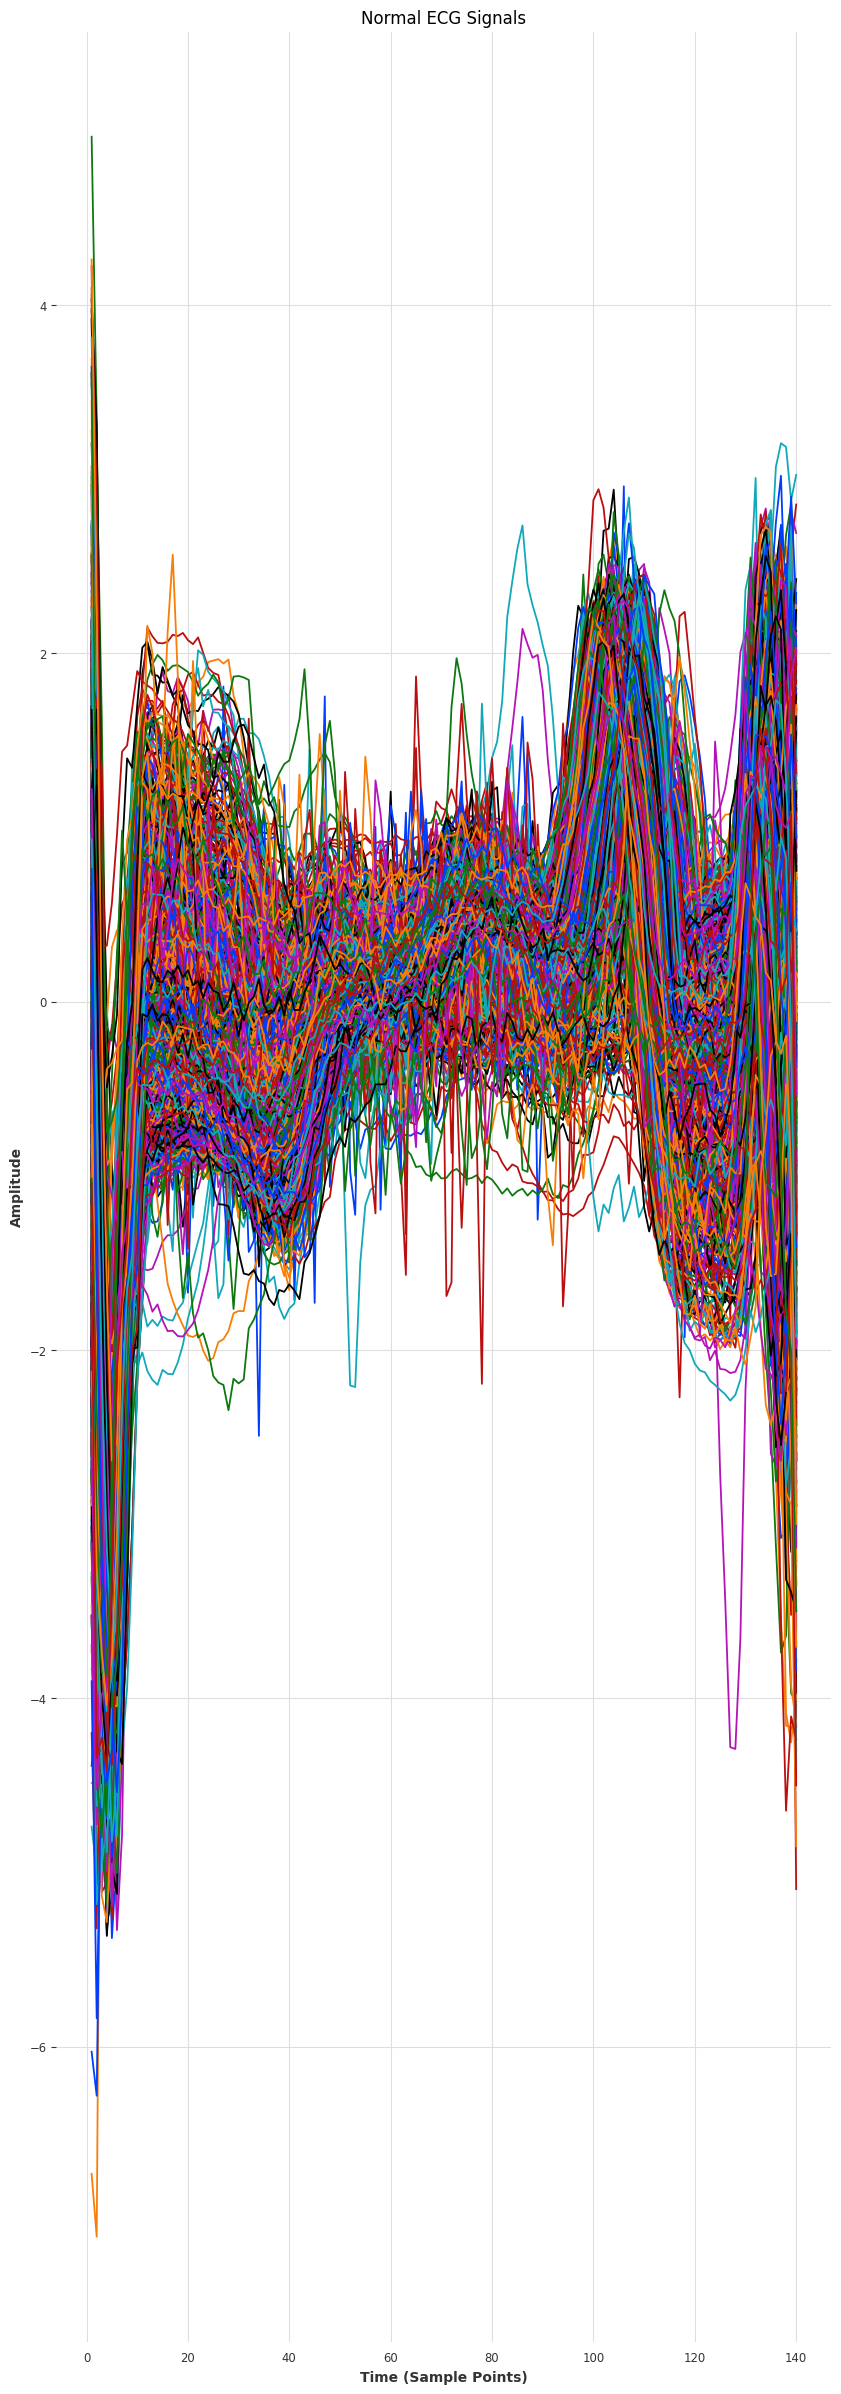

In [78]:
# Extract ECG signal data from the normal_data DataFrame, excluding the first column (assumed to be labels)
ecg_signals = normal_data.iloc[:, 1:]

# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 30))

# Iterate over each row in the ECG signals DataFrame and plot the signal
# The label for each plot is based on the row index (signal number)
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')

# Label the x-axis as 'Time (Sample Points)'
plt.xlabel('Time (Sample Points)')

# Label the y-axis as 'Amplitude'
plt.ylabel('Amplitude')

# Set the title of the plot to 'Normal ECG Signals'
plt.title('Normal ECG Signals')

# Display the plot
plt.show()

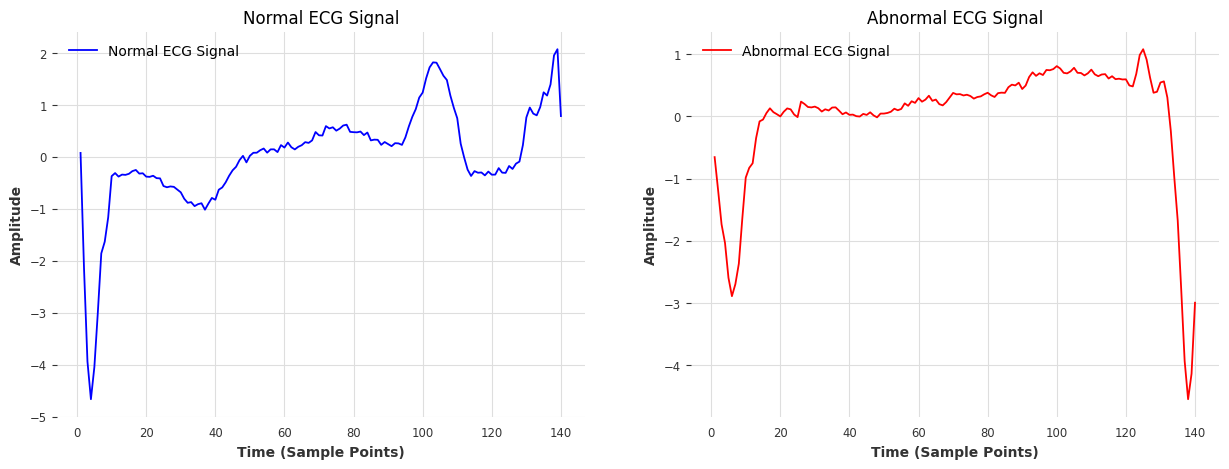

In [80]:
# Extract ECG signals from the normal_data DataFrame, excluding the first column (assumed to be labels)
normal_signals = normal_data.iloc[:, 1:]

# Randomly select one normal ECG signal for visualization
selected_normal_signal = normal_signals.iloc[random.randint(0, len(normal_signals) - 1)]

# Extract ECG signals from the abnormal_data DataFrame, excluding the first column (assumed to be labels)
abnormal_signals = abnormal_data.iloc[:, 1:]

# Randomly select one abnormal ECG signal for visualization
selected_abnormal_signal = abnormal_signals.iloc[random.randint(0, len(abnormal_signals) - 1)]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the selected normal ECG signal on the first subplot
axs[0].plot(selected_normal_signal, label='Normal ECG Signal', color='blue')
axs[0].set_xlabel('Time (Sample Points)')  # Label for x-axis
axs[0].set_ylabel('Amplitude')  # Label for y-axis
axs[0].set_title('Normal ECG Signal')  # Title of the subplot
axs[0].legend()  # Display legend for the subplot

# Plot the selected abnormal ECG signal on the second subplot
axs[1].plot(selected_abnormal_signal, label='Abnormal ECG Signal', color='red')
axs[1].set_xlabel('Time (Sample Points)')  # Label for x-axis
axs[1].set_ylabel('Amplitude')  # Label for y-axis
axs[1].set_title('Abnormal ECG Signal')  # Title of the subplot
axs[1].legend()  # Display legend for the subplot

# Show the plot with both subplots
plt.show()

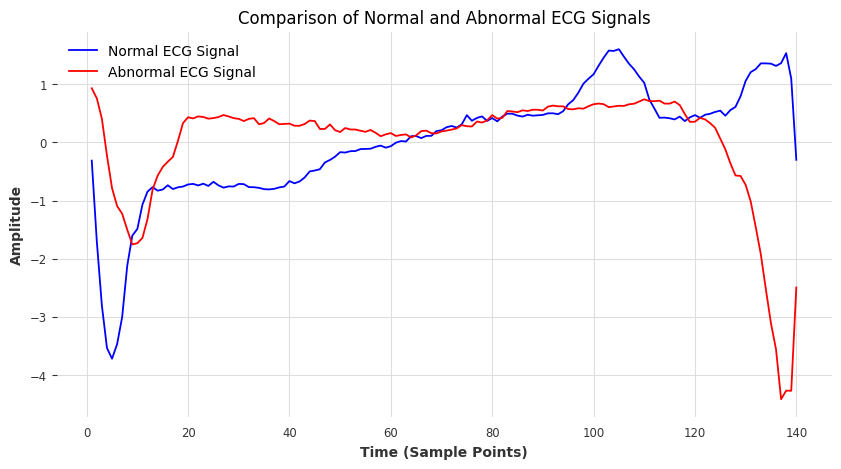

In [81]:
# Extract ECG signals from the normal_data DataFrame, excluding the first column (assumed to be labels)
normal_signals = normal_data.iloc[:, 1:]

# Randomly select one normal ECG signal for visualization
selected_normal_signal = normal_signals.iloc[random.randint(0, len(normal_signals) - 1)]

# Extract ECG signals from the abnormal_data DataFrame, excluding the first column (assumed to be labels)
abnormal_signals = abnormal_data.iloc[:, 1:]

# Randomly select one abnormal ECG signal for visualization
selected_abnormal_signal = abnormal_signals.iloc[random.randint(0, len(abnormal_signals) - 1)]

# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 5))

# Plot the selected normal ECG signal in blue
plt.plot(selected_normal_signal, label='Normal ECG Signal', color='blue')

# Plot the selected abnormal ECG signal in red
plt.plot(selected_abnormal_signal, label='Abnormal ECG Signal', color='red')

# Label the x-axis as 'Time (Sample Points)'
plt.xlabel('Time (Sample Points)')

# Label the y-axis as 'Amplitude'
plt.ylabel('Amplitude')

# Set the title of the plot to 'Comparison of Normal and Abnormal ECG Signals'
plt.title('Comparison of Normal and Abnormal ECG Signals')

# Display the legend to differentiate between normal and abnormal signals
plt.legend()

# Show the plot
plt.show()

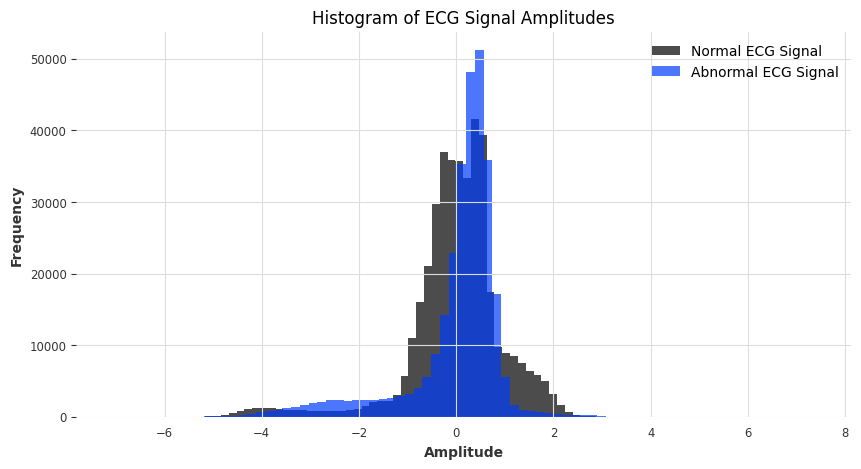

In [82]:
# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 5))

# Plot histograms of ECG signal amplitudes from the normal_data DataFrame
# Use 75 bins for the histogram, with some transparency (alpha) for better visualization
plt.hist(normal_data.iloc[:, 1:].values.flatten(), bins=75, alpha=0.7, label='Normal ECG Signal')

# Plot histograms of ECG signal amplitudes from the abnormal_data DataFrame
# Use 75 bins for the histogram, with some transparency (alpha) for better visualization
plt.hist(abnormal_data.iloc[:, 1:].values.flatten(), bins=75, alpha=0.7, label='Abnormal ECG Signal')

# Label the x-axis as 'Amplitude'
plt.xlabel('Amplitude')

# Label the y-axis as 'Frequency'
plt.ylabel('Frequency')

# Set the title of the plot to 'Histogram of ECG Signal Amplitudes'
plt.title('Histogram of ECG Signal Amplitudes')

# Display the legend to differentiate between normal and abnormal signals
plt.legend()

# Show the plot
plt.show()

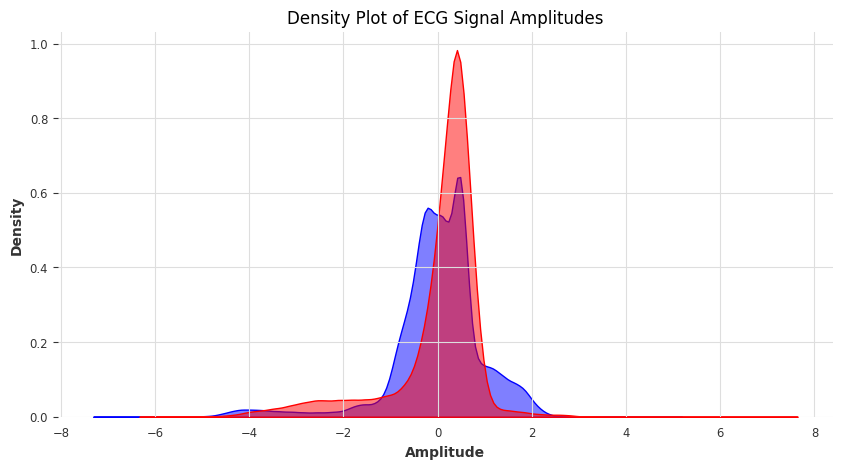

In [83]:
# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 5))

# Plot the density (Kernel Density Estimate) for normal ECG signals
# Use a fill color with some transparency (alpha) and set color to blue
# Disable legend display for this plot
sns.kdeplot(normal_data.iloc[:, 1:].values.flatten(), fill=True, alpha=0.5, color='blue', legend=False)

# Plot the density (Kernel Density Estimate) for abnormal ECG signals
# Use a fill color with some transparency (alpha) and set color to red
# Disable legend display for this plot
sns.kdeplot(abnormal_data.iloc[:, 1:].values.flatten(), fill=True, alpha=0.5, color='red', legend=False)

# Label the x-axis as 'Amplitude'
plt.xlabel('Amplitude')

# Label the y-axis as 'Density'
plt.ylabel('Density')

# Set the title of the plot to 'Density Plot of ECG Signal Amplitudes'
plt.title('Density Plot of ECG Signal Amplitudes')

# Show the plot
plt.show()

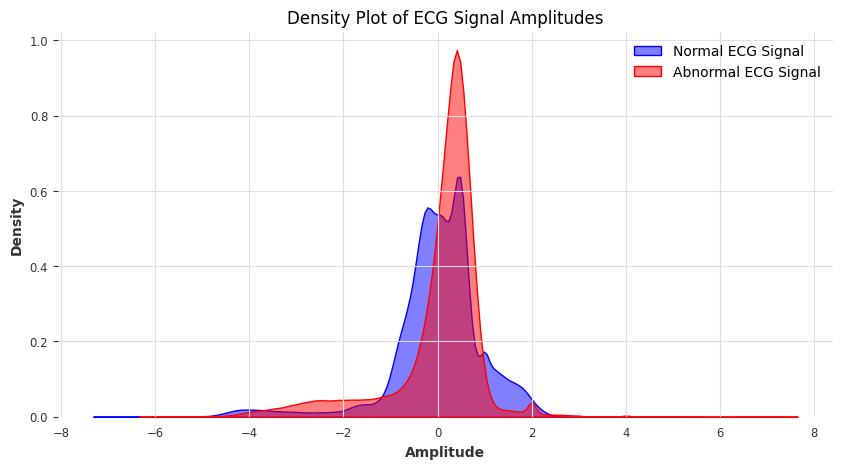

In [84]:
# Flatten the ECG signals from normal_data into a single array for plotting
normal_combined = normal_data.values.flatten()

# Flatten the ECG signals from abnormal_data into a single array for plotting
abnormal_combined = abnormal_data.values.flatten()

# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 5))

# Plot the density (Kernel Density Estimate) for combined normal ECG signals
# Use a fill color with some transparency (alpha), set color to blue, and add a label for the legend
sns.kdeplot(normal_combined, label='Normal ECG Signal', fill=True, alpha=0.5, color='blue')

# Plot the density (Kernel Density Estimate) for combined abnormal ECG signals
# Use a fill color with some transparency (alpha), set color to red, and add a label for the legend
sns.kdeplot(abnormal_combined, label='Abnormal ECG Signal', fill=True, alpha=0.5, color='red')

# Label the x-axis as 'Amplitude'
plt.xlabel('Amplitude')

# Label the y-axis as 'Density'
plt.ylabel('Density')

# Set the title of the plot to 'Density Plot of ECG Signal Amplitudes'
plt.title('Density Plot of ECG Signal Amplitudes')

# Display the legend to differentiate between normal and abnormal signals
plt.legend()

# Show the plot
plt.show()

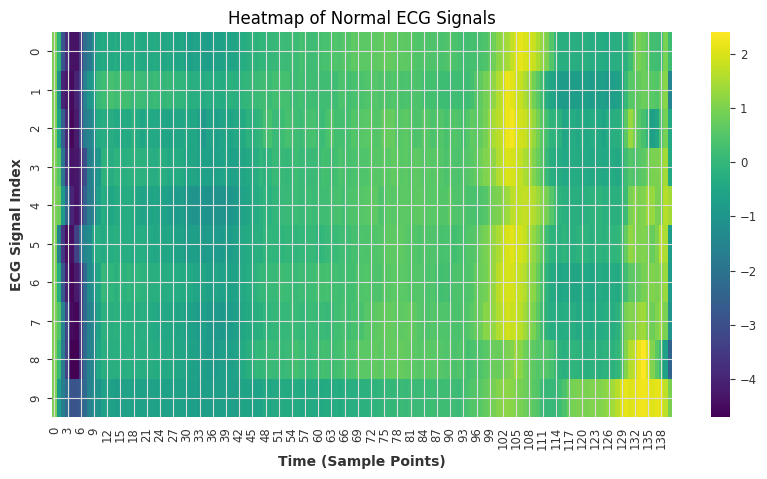

In [85]:
# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 5))

# Plot a heatmap of the first 10 normal ECG signals
# Use the 'viridis' colormap for coloring the heatmap
sns.heatmap(normal_data.iloc[:10, :], cmap='viridis')

# Label the x-axis as 'Time (Sample Points)'
plt.xlabel('Time (Sample Points)')

# Label the y-axis as 'ECG Signal Index'
plt.ylabel('ECG Signal Index')

# Set the title of the plot to 'Heatmap of Normal ECG Signals'
plt.title('Heatmap of Normal ECG Signals')

# Show the plot
plt.show()

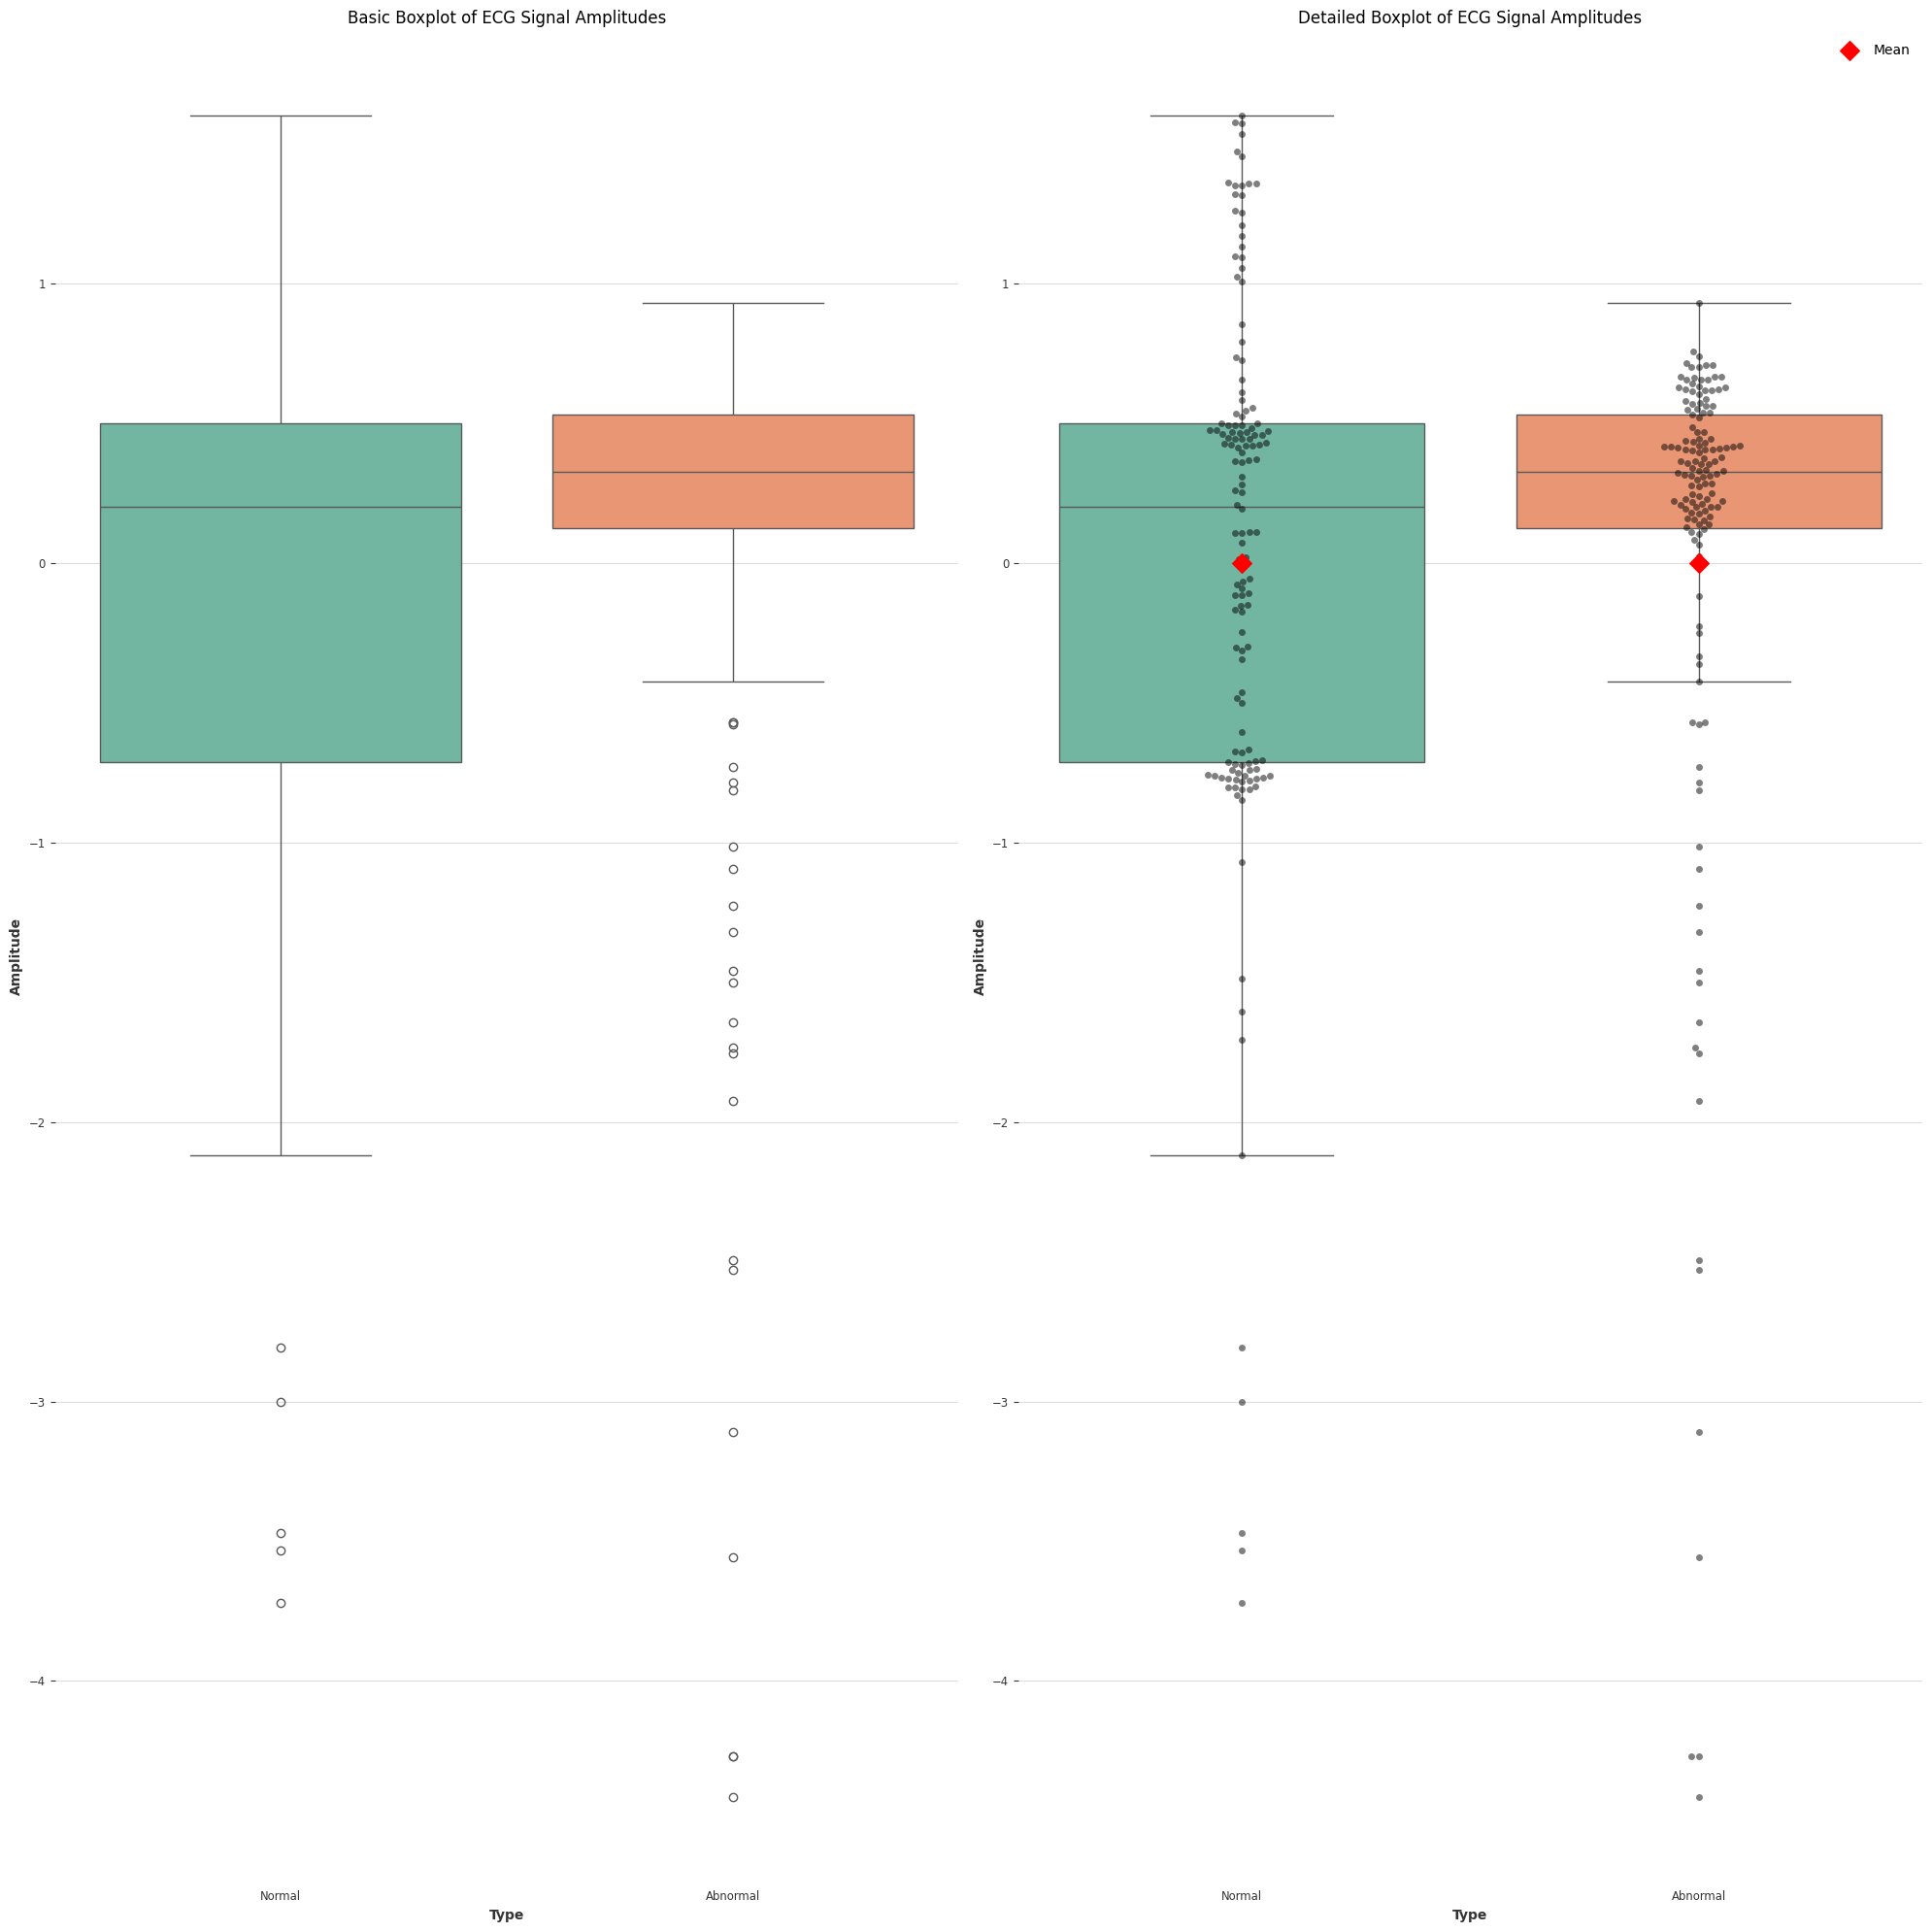

In [86]:
# Create a DataFrame for plotting boxplots
# Combine the selected normal and abnormal signals into a single DataFrame
# Add a column 'Type' to differentiate between 'Normal' and 'Abnormal' signals
boxplot_data = pd.DataFrame({
    'Amplitude': pd.concat([selected_normal_signal, selected_abnormal_signal]),
    'Type': ['Normal'] * len(selected_normal_signal) + ['Abnormal'] * len(selected_abnormal_signal)
})

# Create a new figure for plotting with specified size
plt.figure(figsize=(20, 20))

# Plot a basic boxplot on the left subplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2')
plt.title('Basic Boxplot of ECG Signal Amplitudes')

# Plot a detailed boxplot on the right subplot
plt.subplot(1, 2, 2)
# Create a boxplot without outliers
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2', showfliers=False)
# Overlay a swarm plot to show individual data points
sns.swarmplot(x='Type', y='Amplitude', data=boxplot_data, color='k', alpha=0.5, dodge=True)

# Add mean markers to the detailed boxplot
mean_values = boxplot_data.groupby('Type')['Amplitude'].mean()
for i, mean in enumerate(mean_values):
    plt.scatter(x=i, y=mean, color='red', marker='D', s=100, label='Mean' if i == 0 else "", zorder=10)

plt.title('Detailed Boxplot of ECG Signal Amplitudes')
plt.legend()

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()

# Remove Label column

In [87]:
# Drop the first column (assumed to be labels or non-signal data) from the normal_data DataFrame
# The `inplace=True` argument ensures the changes are applied directly to the original DataFrame
normal_data.drop(normal_data.columns[0], axis=1, inplace=True)

# Drop the first column (assumed to be labels or non-signal data) from the abnormal_data DataFrame
# The `inplace=True` argument ensures the changes are applied directly to the original DataFrame
abnormal_data.drop(abnormal_data.columns[0], axis=1, inplace=True)

In [88]:
# Display the first few rows of the normal_data DataFrame to inspect its contents after removing the first column
normal_data.head()

1         2         3         4         5         6         7    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9         10   ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.160348  0.792168  0.933541  0.796958   
1 -0.992258 -0.754680  0.042321  ...  0.560327  0.538356  0.656881  0.787490   
2 -1.490659 -1.183580 -0.394229  ...  1.284825  0.886073  0.531452  0.311377   
3 -1.671131 -1.333884 -0.965629  ...  0.491173  0.350816  0.499111  0.600345   
4 -1.783423 -1.594450 -0.753199  ...  0.966606  1.148884  0.958434  1.059025   

        135       136       137       138       139       140  
0  0.578621  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.724046  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.021919 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.842069  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.371682  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 140 columns]

In [89]:
# Display the first few rows of the abnormal_data DataFrame to inspect its contents after removing the first column
abnormal_data.head()

1         2         3         4         5         6         7    \
292 -0.032245 -0.545050 -0.822340 -1.605085 -1.805775 -2.008067 -2.233975   
293 -0.003377 -0.279265 -0.230519 -0.635978 -0.894795 -1.023105 -1.243738   
294  0.195989 -0.222258 -0.754773 -1.415614 -1.775851 -2.162326 -2.467492   
295  0.894867 -0.003822 -0.751052 -1.396543 -1.737838 -2.113020 -2.213210   
296  1.250060  0.760800  0.042925 -0.627974 -0.963454 -1.261335 -1.652440   

          8         9         10   ...       131       132       133  \
292 -2.191458 -2.058071 -1.880849  ... -0.906425 -1.621376 -2.329090   
293 -1.458372 -1.677896 -1.784530  ... -2.155969 -2.640508 -3.218384   
294 -2.331384 -1.993476 -1.611709  ... -0.162438 -0.935030 -1.654340   
295 -2.203347 -2.024191 -1.591458  ... -0.899746 -1.441516 -1.861612   
296 -1.888433 -1.935217 -1.808429  ... -0.695282 -0.979223 -1.353969   

          134       135       136       137       138       139       140  
292 -3.049894 -3.620413 -4.210482 -4.043785 -3.051813 -2.806866 -0.879666  
293 -3.651630 -3.881198 -3.924672 -3.164390 -2.228373 -1.837544 -0.378489  
294 -2.434240 -3.472170 -4.280780 -4.629438 -3.794192 -2.851468 -1.743521  
295 -2.321381 -2.884877 -3.530246 -4.412515 -3.903331 -3.567106 -1.536338  
296 -1.952051 -2.640386 -3.000281 -3.812490 -3.973360 -5.221946 -3.661793  

[5 rows x 140 columns]

# Train, Validation and Test Split

In [90]:
# Split the normal_data into training data and remaining data (which will be used for test and validation)
# Use 30% of the data for the remaining set and 70% for the training set
# Set random_state for reproducibility
train_data, temp_data = train_test_split(normal_data, test_size=0.3, random_state=42)

# Split the remaining data (temp_data) into test and validation sets
# Use 50% of the remaining data for testing and 50% for validation
# Set random_state for reproducibility
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the training, validation, and test datasets to verify the splits
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (2043, 140)
Validation Data Shape: (438, 140)
Test Data Shape: (438, 140)


# Scaling

In [91]:
# Initialize RobustScaler for scaling features
scaler = RobustScaler()

# Fit the scaler on the training data and transform the training data
# Transform the validation and test data using the same scaler
train_features_scaled = scaler.fit_transform(train_data)
val_features_scaled = scaler.transform(val_data)
test_features_scaled = scaler.transform(test_data)

# Convert the scaled features back to DataFrames for easier handling
# Use the original column names for consistency
train_data_scaled = pd.DataFrame(train_features_scaled, columns=train_data.columns)
val_data_scaled = pd.DataFrame(val_features_scaled, columns=val_data.columns)
test_data_scaled = pd.DataFrame(test_features_scaled, columns=test_data.columns)

# Remove Index

In [92]:
# Reset the index of the scaled DataFrames to ensure a clean, sequential index
# Drop the old index column and apply changes in place
train_data_scaled.reset_index(drop=True, inplace=True)
val_data_scaled.reset_index(drop=True, inplace=True)
test_data_scaled.reset_index(drop=True, inplace=True)

In [93]:
# Display the first few rows of the scaled training data to inspect its contents
train_data_scaled.head()

1         2         3         4         5         6         7    \
0  0.839248  1.292283  0.987485  0.058345 -0.582377 -0.373762 -0.449916   
1 -0.275807 -0.535190 -0.549554 -0.174845  0.699793  0.944599  0.479219   
2  2.236716  2.393658  2.049168  2.304653  0.539377 -0.421353 -0.344713   
3  1.476550  1.260409  0.854183  0.796802 -1.817792 -1.646699 -1.127945   
4  1.277607  1.551714  2.403606  4.610046  5.983843  3.247492  2.489437   

        8         9         10   ...       131       132       133       134  \
0 -0.664856 -0.589748 -0.197084  ... -0.265375 -0.391869  0.341800  0.030879   
1  0.247840  1.102784  0.345155  ... -0.242300  0.568572  0.447589  0.200100   
2  1.040576 -0.010265  0.077206  ... -3.617046 -4.518786 -3.326732 -2.212527   
3 -0.656004 -0.450035  0.202898  ... -1.802146 -1.332376  0.113713 -0.013878   
4  5.856462  3.375615  2.787641  ... -2.107139 -2.921694 -2.676259 -2.022617   

        135       136       137       138       139       140  
0 -0.143932 -0.335826 -0.122299  0.254380  0.024934 -0.256850  
1  0.281066  0.235796  0.120509 -0.021199  0.342718  0.782722  
2 -1.306004 -0.521562 -0.267923 -0.314913 -0.710822  0.346269  
3  0.549608  0.718334  0.726344  0.189126 -0.472769  0.592118  
4 -1.537035 -1.412944 -1.248509 -1.059544 -0.997188 -0.777456  

[5 rows x 140 columns]

In [94]:
# Display the first few rows of the scaled validation data to inspect its contents
val_data_scaled.head()

1         2         3         4         5         6         7    \
0  0.750357  0.852963  0.965864  0.579018 -0.926328 -0.429219 -0.244146   
1 -0.232572 -0.484082 -0.975487 -1.083936  0.347355  0.930090  0.456502   
2 -1.339746 -0.801949  0.085771  1.537477  3.064569  1.788985  1.001394   
3 -0.110850  0.100078  0.209918  0.430417 -0.349739 -0.709733 -1.014447   
4  0.769570  1.241408  1.233795  1.644781  0.524437 -0.511335 -0.962382   

        8         9         10   ...       131       132       133       134  \
0  0.134767 -0.158884 -0.471762  ... -1.321766  0.246949  0.552940  0.391209   
1  0.376071  1.292512  0.654961  ...  0.203307  1.062086  1.302732  1.830119   
2  2.020424  1.183799 -0.007059  ...  0.494266  0.536919  0.814092  0.698090   
3 -1.103302 -0.274366 -0.880011  ...  0.646830 -0.017139 -0.771633 -1.684558   
4 -1.097533 -0.599829 -0.797315  ... -1.263062 -0.974661  0.590282  0.441693   

        135       136       137       138       139       140  
0  0.221683 -0.181374 -0.697761 -1.177477 -0.638017  0.119817  
1  1.638289  0.812214 -0.121036 -0.477357 -0.543493 -0.681321  
2  0.744623  0.764270  0.655669  0.536940  0.565367  0.602061  
3 -1.889304 -1.673978 -1.516479 -1.121566 -0.869257 -0.726706  
4  0.341100  0.596821  0.090161 -0.555547 -1.052988  0.183906  

[5 rows x 140 columns]

In [95]:
# Display the first few rows of the scaled test data to inspect its contents
test_data_scaled.head()

1         2         3         4         5         6         7    \
0 -0.132394 -0.641296 -0.426380 -0.377511 -0.162521  0.780756  0.481302   
1  0.658419  1.343169  1.101458  1.522987 -0.091359 -0.666563 -0.691936   
2 -0.178278 -0.033876  0.243537 -0.090738 -0.510682 -0.155648  0.033961   
3  0.602227  1.465693  1.771358  2.115425  1.200210 -0.910575 -1.898675   
4  0.420857  0.352492  0.198599 -0.277100 -0.774639 -0.224593 -0.147538   

        8         9         10   ...       131       132       133       134  \
0  0.064879  0.935561  0.897901  ... -0.042536  0.537542  0.401006  0.234686   
1 -1.256640 -0.722822 -0.505430  ... -1.159002 -1.512846 -0.839990  0.172942   
2  0.695595 -0.033554 -0.123223  ... -0.333087  1.442914  1.794423  0.885432   
3 -3.691682 -0.880959 -1.424594  ... -0.621712  0.188786 -0.166474  0.106073   
4 -0.111258 -0.323437 -0.264717  ...  0.353095  0.010004  0.154042  0.156500   

        135       136       137       138       139       140  
0 -0.362604 -0.592130 -0.584513 -0.252685  0.100435 -0.922608  
1  0.137219  0.689427  0.593272  0.444617 -0.119738  0.785213  
2  0.269237 -0.426821 -1.288132 -1.834308 -1.485398 -0.196290  
3  0.011692 -0.204001 -0.687580 -1.372603 -0.972027 -0.147814  
4  0.197993  0.179637  0.181484  0.492402  0.604920  0.270792  

[5 rows x 140 columns]

In [96]:
# Print information about the scaled training data DataFrame
# This includes the number of entries, column data types, and memory usage
train_data_scaled.info()

# Print information about the scaled validation data DataFrame
# This includes the number of entries, column data types, and memory usage
val_data_scaled.info()

# Print information about the scaled test data DataFrame
# This includes the number of entries, column data types, and memory usage
test_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 2.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB


# Adding TimeSeries

In [97]:
# Convert the scaled training data DataFrame to a Darts TimeSeries object
# This format is suitable for time series analysis and forecasting with Darts
train_series = TimeSeries.from_dataframe(train_data_scaled)

# Convert the scaled validation data DataFrame to a Darts TimeSeries object
val_series = TimeSeries.from_dataframe(val_data_scaled)

# Convert the scaled test data DataFrame to a Darts TimeSeries object
test_series = TimeSeries.from_dataframe(test_data_scaled)

# Convert the TimeSeries objects to float32 type for compatibility with models
train_series = train_series.astype(np.float32)
val_series = val_series.astype(np.float32)
test_series = test_series.astype(np.float32)

In [100]:
# Display the first few entries of the training TimeSeries to inspect its contents
train_series.head()

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[ 8.39247704e-01],
        [ 1.29228318e+00],
        [ 9.87485409e-01],
        [ 5.83454520e-02],
        [-5.82376599e-01],
        [-3.73761624e-01],
        [-4.49915498e-01],
        [-6.64856434e-01],
        [-5.89747727e-01],
        [-1.97084084e-01],
        [ 6.87198997e-01],
        [ 5.96488953e-01],
        [ 7.47947544e-02],
        [ 1.91107899e-01],
        [-1.48426056e-01],
        [-2.02052802e-01],
        [-1.39414519e-01],
        [ 8.78619105e-02],
        [ 1.99894458e-01],
        [ 2.66805738e-01],
...
        [-4.28017378e+00],
        [-4.03510714e+00],
        [-4.18219042e+00],
        [-3.99335623e+00],
        [-4.05390215e+00],
        [-4.05564976e+00],
        [-4.16602802e+00],
        [-3.72976947e+00],
        [-2.62017918e+00],
        [-1.61012936e+00],
        [-2.10713840e+00],
        [-2.92169356e+00],
        [-2.67625952e+00],
        [-2.02261662e+00],
        [-1.53703499e+00],
        [-1.41294348e+00],
        [-1.24850881e+00],
        [-1.05954397e+00],
        [-9.97188151e-01],
        [-7.77455807e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [101]:
# Display the first few entries of the validation TimeSeries to inspect its contents
val_series.head()

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[ 7.50357151e-01],
        [ 8.52963269e-01],
        [ 9.65864122e-01],
        [ 5.79018235e-01],
        [-9.26327705e-01],
        [-4.29219246e-01],
        [-2.44146332e-01],
        [ 1.34766966e-01],
        [-1.58884436e-01],
        [-4.71761793e-01],
        [ 1.48806358e-02],
        [ 1.56604871e-01],
        [ 3.25903356e-01],
        [-3.36248018e-02],
        [ 3.00818048e-02],
        [ 5.20868860e-02],
        [ 1.98511362e-01],
        [ 2.64527380e-01],
        [ 1.06026515e-01],
        [ 4.81281519e-01],
...
        [ 7.01315403e-02],
        [-5.72296418e-02],
        [ 1.48328856e-01],
        [ 2.03496814e-01],
        [-6.56103855e-03],
        [-2.00159084e-02],
        [-1.48976922e-01],
        [-3.89114290e-01],
        [-5.93819499e-01],
        [-8.14140618e-01],
        [-1.26306200e+00],
        [-9.74660575e-01],
        [ 5.90282321e-01],
        [ 4.41692859e-01],
        [ 3.41100216e-01],
        [ 5.96821189e-01],
        [ 9.01606679e-02],
        [-5.55546701e-01],
        [-1.05298793e+00],
        [ 1.83906168e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [102]:
# Display the first few entries of the test TimeSeries to inspect its contents
test_series.head()

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[-1.32393837e-01],
        [-6.41295791e-01],
        [-4.26379889e-01],
        [-3.77510995e-01],
        [-1.62520975e-01],
        [ 7.80756176e-01],
        [ 4.81302053e-01],
        [ 6.48785233e-02],
        [ 9.35561359e-01],
        [ 8.97900760e-01],
        [ 6.48413479e-01],
        [ 4.37062055e-01],
        [ 4.98988122e-01],
        [ 4.21544790e-01],
        [ 6.36175573e-01],
        [ 7.15150714e-01],
        [ 5.25784612e-01],
        [ 1.82345390e-01],
        [ 7.53757581e-02],
        [ 4.92000096e-02],
...
        [ 1.83541745e-01],
        [-4.54273932e-02],
        [ 2.91098237e-01],
        [ 2.26096272e-01],
        [ 1.85477689e-01],
        [ 2.89207757e-01],
        [ 2.22837493e-01],
        [ 1.94250301e-01],
        [ 3.10655236e-01],
        [ 4.53027159e-01],
        [ 3.53094995e-01],
        [ 1.00044012e-02],
        [ 1.54041767e-01],
        [ 1.56499520e-01],
        [ 1.97992906e-01],
        [ 1.79637328e-01],
        [ 1.81483626e-01],
        [ 4.92401630e-01],
        [ 6.04920030e-01],
        [ 2.70791829e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Model Architecture

In [103]:
# Custom callback to log training and validation losses
class LossLoggingCallback(Callback):
    def __init__(self):
        # Initialize storage for metrics
        self.metrics = {"epochs": [], "train_loss": [], "val_loss": []}
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        """
        Called at the end of each training epoch.
        Retrieves and logs the training loss.
        """
        # Get training loss from the callback metrics
        train_loss = trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            train_loss = train_loss.item()
            self.train_losses.append(train_loss)
            print(f"Train epoch end: recorded train loss {train_loss}")

    def on_validation_epoch_end(self, trainer, pl_module):
        """
        Called at the end of each validation epoch.
        Retrieves and logs the validation loss.
        """
        # Get validation loss from the callback metrics
        val_loss = trainer.callback_metrics.get("val_loss", None)
        print("Validation Epoch End Callback Triggered")  # Debugging Line
        if val_loss is not None:
            val_loss = val_loss.item()
            self.val_losses.append(val_loss)
            print(f"Validation epoch end: recorded validation loss {val_loss}")

            # Update metrics with current epoch loss values
            epoch = trainer.current_epoch
            self.metrics["epochs"].append(epoch)
            self.metrics["train_loss"].append(self.train_losses[-1] if self.train_losses else None)
            self.metrics["val_loss"].append(val_loss)


# Define the TCN (Temporal Convolutional Network) model
ecg_model = TCNModel(
    input_chunk_length=50,   # Length of input sequence
    output_chunk_length=30,  # Length of output sequence
    kernel_size=3,           # Size of the convolution kernel
    num_filters=32,          # Number of filters in the convolutional layers
    num_layers=3,            # Number of convolutional layers
    dropout=0.2,             # Dropout rate for regularization
    optimizer_cls=Adam,      # Optimizer class to use for training
    optimizer_kwargs={"lr": 0.001},  # Optimizer parameters, such as learning rate
    random_state=42          # Seed for reproducibility of results
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",      # Metric to monitor for early stopping
    patience=10,             # Number of epochs to wait for improvement before stopping
    mode="min"               # Mode should be 'min' for loss metrics (lower is better)
)

# Create an instance of the loss logging callback
loss_callback = LossLoggingCallback()

# Initialize the Trainer with callbacks and training parameters
trainer = Trainer(
    callbacks=[early_stopping_callback, loss_callback],  # List of callbacks to use during training
    max_epochs=100,                                       # Maximum number of epochs for training
    logger=True,                                         # Enable logging to track training progress
    enable_progress_bar=True                             # Show progress bar during training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [104]:
# Fit the ECG model using the training data and validation data
# The `trainer` instance handles the training process, including callbacks and logging
ecg_model.fit(
    train_series,         # The training TimeSeries data
    val_series=val_series, # The validation TimeSeries data
    trainer=trainer       # The PyTorch Lightning Trainer instance to manage training
)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 48.6 K | train
-------------------------------------------------------------
48.6 K    Trainable params
0         Non-trainable params
48.6 K    Total params
0.194     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.27it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0113868713378906
Epoch 0: 100%|██████████| 62/62 [00:03<00:00, 16.03it/s, v_num=32, train_loss=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 53.26it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0361645221710205

Epoch 1: 100%|██████████| 62/62 [00:02<00:00, 24.78it/s, v_num=32, train_loss=0.884, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 63.09it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0399836301803589

Epoch 2: 100%|██████████| 62/62 [00:02<00:00, 25.72it/s, v_num=32, train_loss=0.769, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=32, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=30, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, random_state=42)

In [112]:
# Ensure that lengths for epochs, train_losses, and val_losses are consistent
# Create a range object for epochs based on the number of training losses recorded
epochs = range(len(loss_callback.train_losses))

# Check the number of recorded training and validation epochs
num_train_epochs = len(loss_callback.train_losses)
num_val_epochs = len(loss_callback.val_losses)

# If there are more validation losses recorded than training losses,
# trim the validation losses to match the number of training epochs
if num_val_epochs > num_train_epochs:
    loss_callback.val_losses = loss_callback.val_losses[:num_train_epochs]

# You can now proceed with plotting or further analysis, ensuring the data is consistent

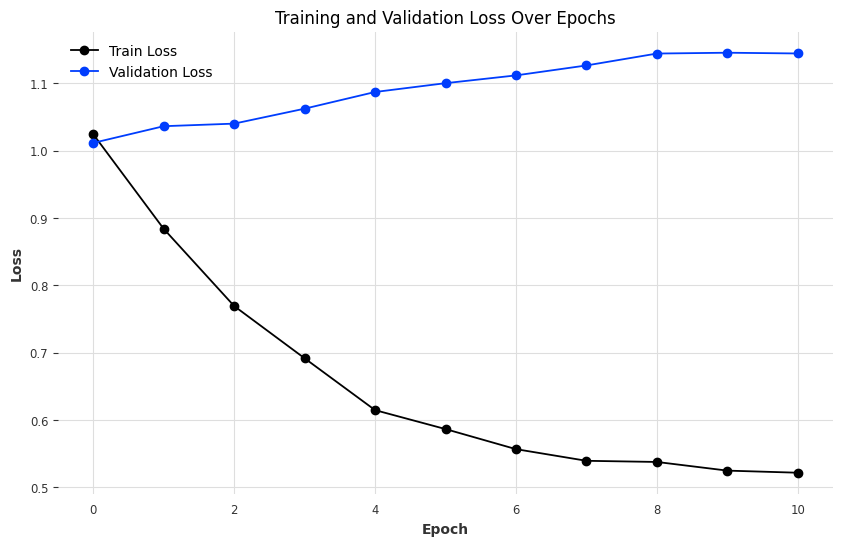

In [113]:
import matplotlib.pyplot as plt

# Plot the training and validation losses over epochs
plt.figure(figsize=(10, 6))  # Create a figure with specific size

# Plot training loss with markers
plt.plot(
    epochs,                      # X-axis: epoch numbers
    loss_callback.train_losses,  # Y-axis: training losses
    label='Train Loss',          # Label for the training loss curve
    marker='o'                   # Use circle markers for data points
)

# Plot validation loss with markers
plt.plot(
    epochs,                       # X-axis: epoch numbers
    loss_callback.val_losses,     # Y-axis: validation losses
    label='Validation Loss',      # Label for the validation loss curve
    marker='o'                    # Use circle markers for data points
)

# Set labels for the X and Y axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set the title of the plot
plt.title('Training and Validation Loss Over Epochs')

# Add a legend to differentiate between training and validation loss
plt.legend()

# Enable grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# Forecasting Anomaly Model

In [114]:
# Transform the abnormal data using the previously fitted RobustScaler
# This ensures that the abnormal data is scaled in the same way as the training data
abnormal_features_scaled = scaler.transform(abnormal_data)

# Convert the scaled features into a DataFrame
# This DataFrame uses the same column names as the test data to maintain consistency
abnormal_data_scaled = pd.DataFrame(
    abnormal_features_scaled,  # The scaled feature values
    columns=test_data.columns  # Use column names from the test data
)

In [115]:
# Convert the scaled abnormal data into a TimeSeries object
# This conversion allows the data to be used with models and functions that require TimeSeries inputs
abnormal_series = TimeSeries.from_dataframe(abnormal_data_scaled)

# Convert the TimeSeries data to float32 type for consistency with model requirements
# This is often done to match the data type used in model training
abnormal_series = abnormal_series.astype(np.float32)

In [116]:
# Instantiate the anomaly detection model
# The model combines a forecasting model with anomaly detection scorers
anomaly_model = ForecastingAnomalyModel(
    model=ecg_model,  # The forecasting model used for anomaly detection, in this case, a TCNModel
    scorer=[          # List of scorers used for evaluating anomalies
        NormScorer(ord=1),  # Scorer for detecting anomalies based on normalization
    ],
)

In [117]:
# Define the starting threshold for the anomaly detection process
START = 0.1

In [118]:
# Fit the anomaly detection model using the scaled training data
# `START` is used as a parameter to configure the fitting process or threshold for anomaly detection
# `allow_model_training=False` indicates that the model should not be retrained during the fitting
# `verbose=True` enables detailed output during the fitting process
# `scorer=NormScorer` specifies the scorer used for evaluating anomalies (this should be a class, not an instance)
anomaly_model.fit(
    series=train_series,          # Training time series data
    start=START,                 # Starting value for a parameter or threshold used in fitting
    allow_model_training=False,  # Prevent the model from retraining during the fitting process
    verbose=True,                # Enable detailed logging of the fitting process
    scorer=NormScorer            # Scorer class used for anomaly detection evaluation
)

In [119]:
# Calculate anomaly scores for the test series using the fitted anomaly model
# `START` is used as a parameter to configure the scoring process or threshold for anomaly detection
# `return_model_prediction=True` indicates that the model's forecast should be returned along with the anomaly scores
# `verbose=True` enables detailed output during the scoring process
anomaly_scores, model_forecasting = anomaly_model.score(
    test_series,                # The time series data to score for anomalies
    start=START,               # Starting value for the scoring process or threshold
    return_model_prediction=True,  # Return the model's forecast predictions alongside anomaly scores
    verbose=True               # Enable detailed logging of the scoring process
)

# Get the start time of the model forecasting for further analysis or plotting
pred_start = model_forecasting.start_time()

`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 20.31it/s]


In [121]:
# Extract the anomaly scores from the result of the anomaly detection model
# `anomaly_scores` contains the computed scores that indicate the degree of anomaly at each time point in the test series
anomaly_scores

<TimeSeries (DataArray) (time: 388, component: 1, sample: 1)> Size: 2kB
array([[[103.76747 ]],

       [[ 81.67398 ]],

       [[137.62512 ]],

       [[212.435   ]],

       [[ 46.949913]],

       [[ 51.2405  ]],

       [[ 93.53491 ]],

       [[ 74.98307 ]],

       [[ 85.80118 ]],

       [[ 61.635635]],

...

       [[248.45557 ]],

       [[265.26654 ]],

       [[113.98107 ]],

       [[ 59.482273]],

       [[153.27286 ]],

       [[120.700554]],

       [[ 81.80315 ]],

       [[ 42.34995 ]],

       [[ 80.882095]],

       [[ 83.71193 ]]], dtype=float32)
Coordinates:
  * time       (time) int64 3kB 50 51 52 53 54 55 56 ... 432 433 434 435 436 437
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [122]:
# Extract the time index and values from the TimeSeries object containing anomaly scores
time_index = anomaly_scores.time_index  # Get the time index for the anomaly scores
scores = anomaly_scores.values()        # Get the anomaly score values

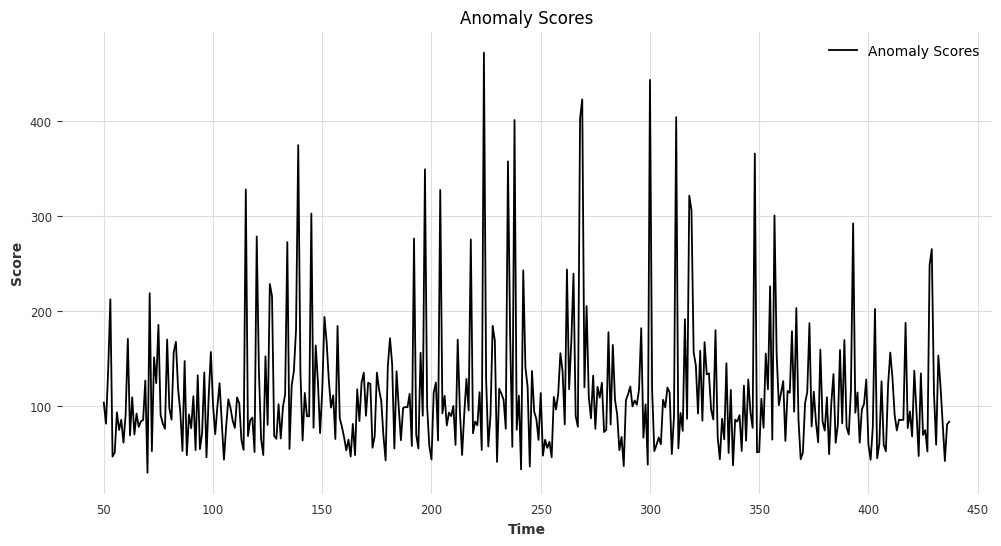

In [123]:
# Plot the anomaly scores
plt.figure(figsize=(12, 6))               # Set the figure size for the plot
plt.plot(time_index, scores, label="Anomaly Scores")  # Plot the anomaly scores against time
plt.xlabel('Time')                       # Label for the x-axis
plt.ylabel('Score')                      # Label for the y-axis
plt.title('Anomaly Scores')             # Title of the plot
plt.legend()                            # Add legend to the plot
plt.show()                              # Display the plot

In [124]:
# Calculate the Mean Absolute Error (MAE) between the model forecasts and the actual test series
# `model_forecasting` contains the forecasts made by the model
# `test_series` is the actual time series data for comparison
# The MAE measures the average magnitude of errors between forecasts and actual values
mae_score = mae(model_forecasting, test_series)

# Print the MAE score
print(f"Mean Absolute Error (MAE): {mae_score}")

Mean Absolute Error (MAE): 0.8212010264396667


In [125]:
# Calculate the Root Mean Squared Error (RMSE) between the model forecasts and the actual test series
# `model_forecasting` contains the forecasts made by the model
# `test_series` is the actual time series data for comparison
# The RMSE measures the square root of the average squared differences between forecasts and actual values
rmse_score = rmse(model_forecasting, test_series)

# Print the RMSE score
print(f"Root Mean Squared Error (RMSE): {rmse_score}")

Root Mean Squared Error (RMSE): 1.142357349395752


In [126]:
# Calculate anomaly scores on the validation data
# `val_series` is the validation time series data on which to compute anomaly scores
# `anomaly_model.score` returns both the anomaly scores and the model forecasts for the validation data
# `START` is the parameter specifying the starting point for anomaly scoring
# `return_model_prediction=True` ensures that the model's forecasts are also returned
# `verbose=True` enables detailed logging of the scoring process

val_anomaly_scores, val_model_forecasting = anomaly_model.score(
    val_series, start=START, return_model_prediction=True, verbose=True
)

# Extract the starting time of the forecasts
pred_start = val_model_forecasting.start_time()

`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 22.05it/s]


In [127]:
# `val_anomaly_scores` contains the calculated anomaly scores for the validation dataset.
# It is a TimeSeries object with scores indicating the degree of anomalies detected by the model.
val_anomaly_scores

<TimeSeries (DataArray) (time: 388, component: 1, sample: 1)> Size: 2kB
array([[[ 40.45376 ]],

       [[139.53375 ]],

       [[146.15578 ]],

       [[146.81085 ]],

       [[ 37.9077  ]],

       [[ 80.37741 ]],

       [[ 89.1257  ]],

       [[ 84.745865]],

       [[ 70.4312  ]],

       [[ 60.712597]],

...

       [[ 59.386436]],

       [[ 75.879135]],

       [[194.05972 ]],

       [[151.35233 ]],

       [[145.25453 ]],

       [[120.19014 ]],

       [[110.195206]],

       [[ 67.72292 ]],

       [[101.57531 ]],

       [[ 86.378105]]], dtype=float32)
Coordinates:
  * time       (time) int64 3kB 50 51 52 53 54 55 56 ... 432 433 434 435 436 437
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [129]:
# Convert time index and scores to numpy arrays if they are not already in that format
time_index = np.array(time_index)  # Ensure time index is a numpy array
scores = np.array(scores)  # Ensure scores are a numpy array

# Calculate z-scores to standardize the anomaly scores
# Z-scores are computed to identify how many standard deviations a score is from the mean
mean_score = np.mean(scores)  # Calculate the mean of the scores
std_dev_score = np.std(scores)  # Calculate the standard deviation of the scores
z_scores = (scores - mean_score) / std_dev_score  # Compute z-scores for each score

# Define the threshold for anomaly detection
# Anomalies are detected if their z-scores exceed this threshold
threshold = 3  # Threshold for detecting anomalies (z-score > 3)
anomalies = z_scores > threshold  # Boolean array where True indicates an anomaly
anomalies # Return anomalies

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [130]:
# Print the types and shapes of the variables
print(f"Type of time_index: {type(time_index)}")  # Output the type of time_index
print(f"Shape of time_index: {np.shape(time_index)}")  # Output the shape of time_index
print(f"Type of scores: {type(scores)}")  # Output the type of scores
print(f"Shape of scores: {np.shape(scores)}")  # Output the shape of scores
print(f"Type of anomalies: {type(anomalies)}")  # Output the type of anomalies
print(f"Shape of anomalies: {np.shape(anomalies)}")  # Output the shape of anomalies

# Convert to numpy arrays if they are not already
# Ensure that time_index, scores, and anomalies are numpy arrays
if not isinstance(time_index, np.ndarray):
    time_index = np.array(time_index)  # Convert time_index to numpy array if it is not already
if not isinstance(scores, np.ndarray):
    scores = np.array(scores)  # Convert scores to numpy array if it is not already
if not isinstance(anomalies, np.ndarray):
    anomalies = np.array(anomalies)  # Convert anomalies to numpy array if it is not already

# Verify the shapes after conversion
print(f"Converted type of time_index: {type(time_index)}")  # Output the type of time_index after conversion
print(f"Shape of time_index after conversion: {np.shape(time_index)}")  # Output the shape of time_index after conversion
print(f"Converted type of scores: {type(scores)}")  # Output the type of scores after conversion
print(f"Shape of scores after conversion: {np.shape(scores)}")  # Output the shape of scores after conversion
print(f"Converted type of anomalies: {type(anomalies)}")  # Output the type of anomalies after conversion
print(f"Shape of anomalies after conversion: {np.shape(anomalies)}")  # Output the shape of anomalies after conversion

Type of time_index: <class 'numpy.ndarray'>
Shape of time_index: (388,)
Type of scores: <class 'numpy.ndarray'>
Shape of scores: (388, 1)
Type of anomalies: <class 'numpy.ndarray'>
Shape of anomalies: (388, 1)
Converted type of time_index: <class 'numpy.ndarray'>
Shape of time_index after conversion: (388,)
Converted type of scores: <class 'numpy.ndarray'>
Shape of scores after conversion: (388, 1)
Converted type of anomalies: <class 'numpy.ndarray'>
Shape of anomalies after conversion: (388, 1)


In [131]:
# Flatten the scores and anomalies arrays to 1D
scores = scores.flatten()  # Convert the scores array to a 1D array if it is not already
anomalies = anomalies.flatten()  # Convert the anomalies array to a 1D array if it is not already

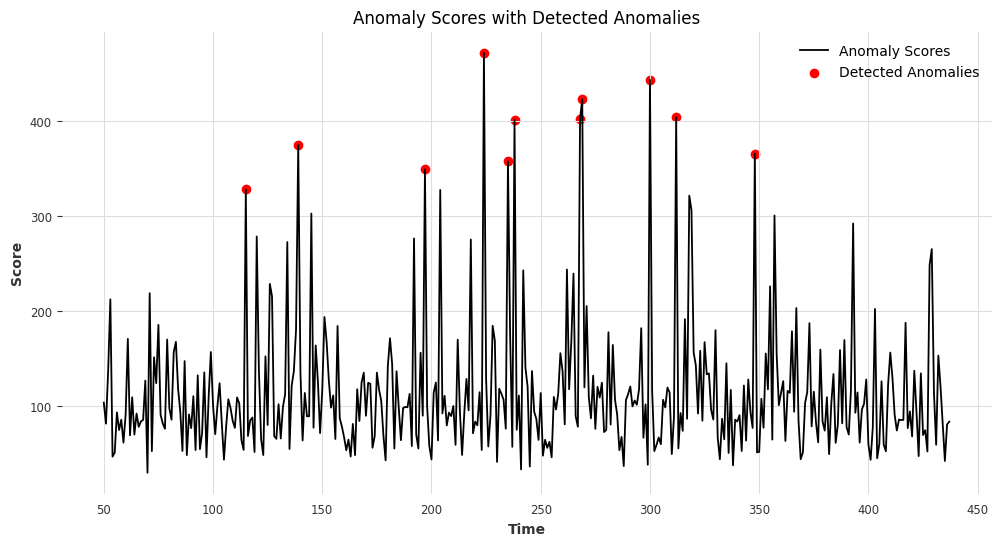

In [132]:
# Plot the anomaly scores
plt.figure(figsize=(12, 6))  # Create a figure with a specified size
plt.plot(time_index, scores, label="Anomaly Scores")  # Plot the anomaly scores over time
plt.scatter(time_index[anomalies], scores[anomalies], color='red', label="Detected Anomalies")  # Scatter plot for detected anomalies
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Score')  # Label for the y-axis
plt.title('Anomaly Scores with Detected Anomalies')  # Title for the plot
plt.legend()  # Display the legend
plt.show()  # Show the plot

In [133]:
# Print the indices of detected anomalies
print("Anomaly indices:", np.where(anomalies)[0])  # Output the indices where anomalies are detected

Anomaly indices: [ 65  89 147 174 185 188 218 219 250 262 298]


In [134]:
# Define the chunk size
chunk_size = 50  # Specify the size of each chunk for processing or analysis

In [135]:
# Function to calculate anomaly scores for each chunk
def calculate_anomaly_scores_by_chunk(time_index, scores, chunk_size, threshold=3):
    """
    Calculate anomaly scores and detect anomalies for each chunk of data.

    Parameters:
    - time_index: Array of time indices corresponding to the anomaly scores
    - scores: Array of anomaly scores
    - chunk_size: Size of each chunk to process
    - threshold: Z-score threshold for anomaly detection (default is 3)

    Returns:
    - combined_anomalies: Array of anomaly detection results for all chunks
    - combined_scores: Array of scores for all chunks
    """
    num_chunks = len(time_index) // chunk_size  # Calculate the number of chunks
    if len(time_index) % chunk_size != 0:
        num_chunks += 1  # Account for any remaining data that does not fit perfectly into chunks

    all_anomalies = []  # List to store anomalies detected in each chunk
    all_scores = []     # List to store scores for each chunk

    for i in range(num_chunks):
        start_idx = i * chunk_size  # Start index of the current chunk
        end_idx = min((i + 1) * chunk_size, len(time_index))  # End index of the current chunk
        
        # Extract chunk of time indices and scores
        chunk_time_index = time_index[start_idx:end_idx]
        chunk_scores = scores[start_idx:end_idx]
        
        # Compute mean and standard deviation for the current chunk
        mean_score = np.mean(chunk_scores)
        std_dev_score = np.std(chunk_scores)
        
        # Compute z-scores and detect anomalies
        z_scores = (chunk_scores - mean_score) / std_dev_score
        anomalies = z_scores > threshold  # Determine anomalies based on the threshold
        
        # Append results for the current chunk
        all_anomalies.append(anomalies)
        all_scores.append(chunk_scores)
        
    # Combine results from all chunks
    combined_anomalies = np.concatenate(all_anomalies)
    combined_scores = np.concatenate(all_scores)
    
    return combined_anomalies, combined_scores  # Return combined anomalies and scores

In [136]:
# Calculate anomaly scores by chunk
chunk_anomalies, chunk_scores = calculate_anomaly_scores_by_chunk(time_index, scores, chunk_size)

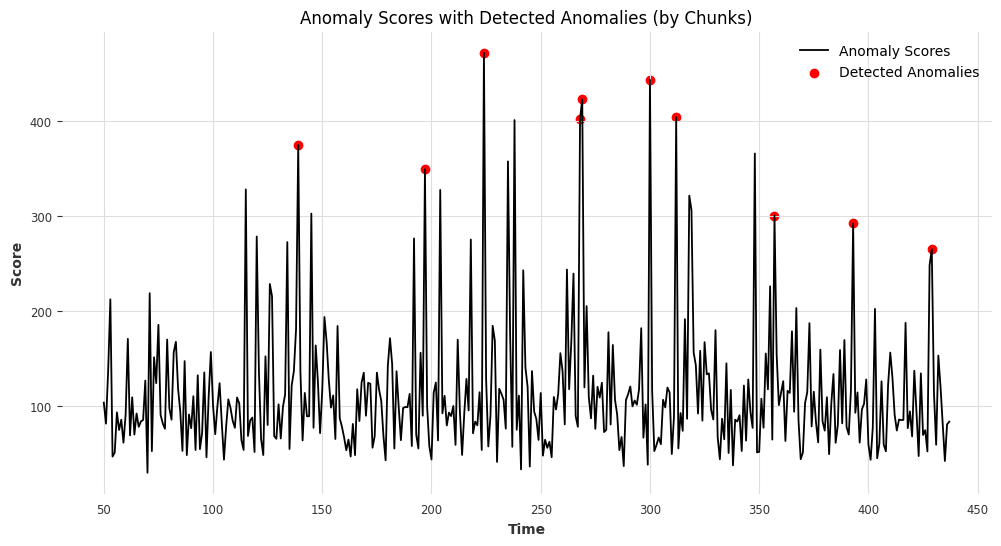

In [137]:
# Plot the anomaly scores
plt.figure(figsize=(12, 6))
plt.plot(time_index, chunk_scores, label="Anomaly Scores")  # Plot all anomaly scores
plt.scatter(time_index[chunk_anomalies], chunk_scores[chunk_anomalies], color='red', label="Detected Anomalies")  # Highlight detected anomalies
plt.xlabel('Time')
plt.ylabel('Score')
plt.title('Anomaly Scores with Detected Anomalies (by Chunks)')  # Title of the plot
plt.legend()  # Display the legend
plt.show()  # Show the plot

In [138]:
# Print the indices of detected anomalies
print("Anomaly indices:", np.where(chunk_anomalies)[0])  # Output the indices where anomalies were detected

Anomaly indices: [ 89 147 174 218 219 250 262 307 343 379]


In [139]:
# Example data: Replace these with your actual data
time_index = np.arange(len(scores))  # Generate a sequential time index based on the length of scores
normal_data = np.random.normal(0, 1, len(scores))  # Generate example normal ECG data; replace with actual data
anomalous_data = np.random.normal(0, 1, len(scores))  # Generate example anomalous ECG data; replace with actual data

In [140]:
# Function to plot ECG data with anomalies
def plot_ecg_with_anomalies(time_index, normal_data, anomalous_data, scores, anomalies, threshold=3):
    """
    Plots ECG data with detected anomalies and anomaly scores.

    Parameters:
    - time_index (array-like): An array or list representing the time indices for the ECG data.
    - normal_data (array-like): An array or list of normal ECG data values.
    - anomalous_data (array-like): An array or list of anomalous ECG data values.
    - scores (array-like): Anomaly scores computed for each data point.
    - anomalies (array-like): A boolean array or list indicating detected anomalies (True for anomalies).
    - threshold (float): The threshold value for anomaly detection (default is 3).

    The function creates a plot with the following components:
    - Normal ECG data is plotted in blue.
    - Anomalous ECG data is plotted in orange.
    - Anomaly scores are plotted as a green dashed line.
    - Detected anomalies are highlighted with red 'x' markers.
    - A horizontal dashed red line indicates the threshold value for anomaly detection.

    The plot provides a visual representation of the ECG data, highlighting where anomalies are detected based on the computed scores.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot normal ECG data
    plt.plot(time_index, normal_data, label="Normal ECG Data", color='blue', alpha=0.5)
    
    # Plot anomalous ECG data
    plt.plot(time_index, anomalous_data, label="Anomalous ECG Data", color='orange', alpha=0.5)
    
    # Plot anomaly scores
    plt.plot(time_index, scores, label="Anomaly Scores", color='green', linestyle='--', alpha=0.7)
    
    # Highlight detected anomalies
    plt.scatter(time_index[anomalies], scores[anomalies], color='red', label="Detected Anomalies", marker='x')
    
    # Add a horizontal line representing the threshold for anomalies
    plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold")
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ECG Data with Detected Anomalies')
    plt.legend()
    plt.show()

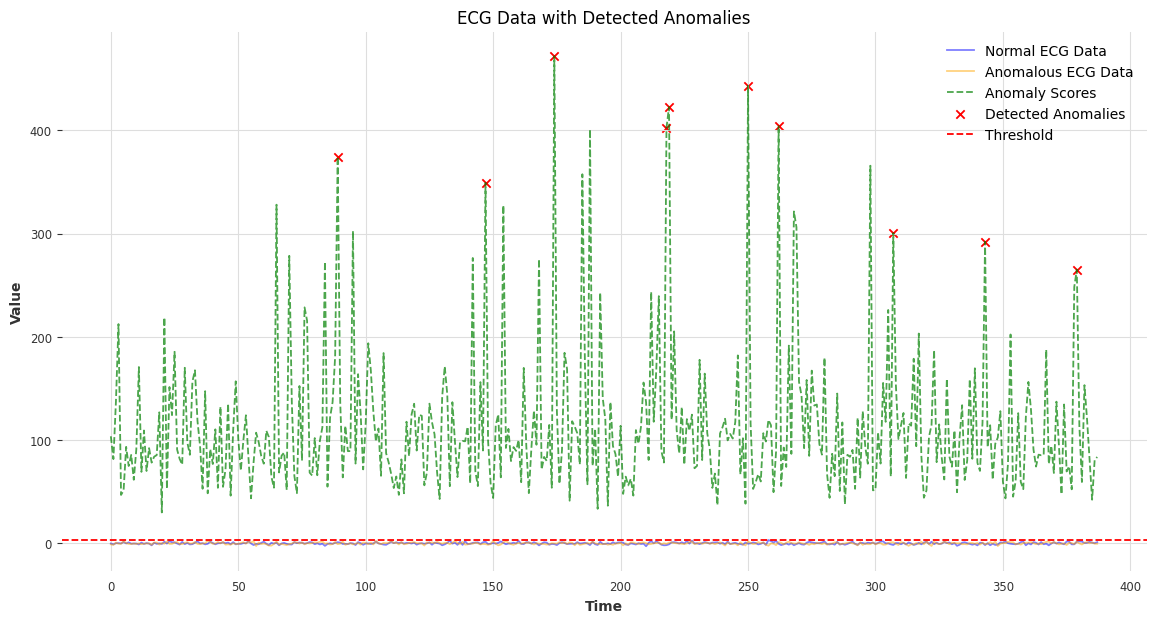

In [143]:
# Example usage
plot_ecg_with_anomalies(time_index, normal_data, anomalous_data, scores, chunk_anomalies)

ValueError: x and y must have same first dimension, but have shapes (100,) and (388,)

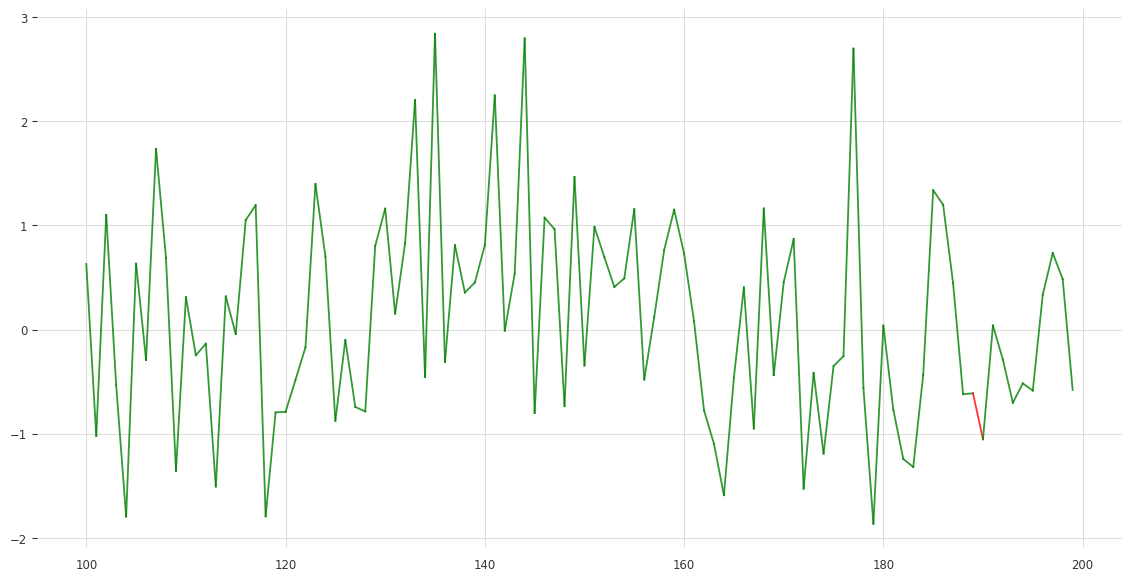

In [144]:
# Function to plot a chunk of ECG data with normal and anomalous segments
def plot_ecg_chunk_with_normal_and_anomalous_segments(time_index, ecg_data, scores, anomalies, threshold):
    plt.figure(figsize=(14, 7))
    
    # Plot segments with different colors for normal and anomalous data
    current_color = 'green'
    for i in range(len(time_index) - 1):
        # Switch color to red if an anomaly is detected
        if anomalies[i]:
            plt.plot(time_index[i:i+2], ecg_data[i:i+2], color='red', alpha=0.8)
        else:
            plt.plot(time_index[i:i+2], ecg_data[i:i+2], color=current_color, alpha=0.8)
    
    # Plot anomaly scores
    plt.plot(time_index, scores, label="Anomaly Scores", color='blue', linestyle='--', alpha=0.7)
    
    # Highlight detected anomalies
    plt.scatter(time_index[anomalies], scores[anomalies], color='red', label="Detected Anomalies", marker='x')
    
    # Plot the threshold line
    plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold")
    
    # Set labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('ECG Value')
    plt.title('ECG Chunk with Normal and Anomalous Points')
    plt.legend()
    plt.show()

# Plot the chunk
plot_ecg_chunk_with_normal_and_anomalous_segments(chunk_time_index, chunk_ecg_data, chunk_scores, chunk_anomalies, threshold)

In [59]:
print("Time Index Chunk:", chunk_time_index)
print("ECG Data Chunk:", chunk_ecg_data)
print("Anomalies Chunk:", chunk_anomalies)

Time Index Chunk: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
ECG Data Chunk: [ 0.62855523 -1.01979815  1.09963152 -0.53616784 -1.79395288  0.63143258
 -0.29335238  1.73157965  0.6875548  -1.35702189  0.3103137  -0.24679653
 -0.1360656  -1.50641312  0.31730935 -0.04357709  1.04903663  1.19295245
 -1.79197965 -0.79527411 -0.79013431 -0.48191446 -0.17063051  1.39584484
  0.70086405 -0.87539717 -0.10061797 -0.74251851 -0.78589037  0.80230206
  1.15940495  0.15293631  0.82842061  2.20174872 -0.4548219   2.8370719
 -0.31148341  0.80929776  0.35473342  0.45095131  0.80784314  2.24570121
 -0.0116961   0.53721554  2.79267043 -0.80102256 

In [60]:
if np.any(chunk_anomalies):
    print("Anomalies detected in chunk.")
else:
    print("No anomalies detected in chunk.")


Anomalies detected in chunk.


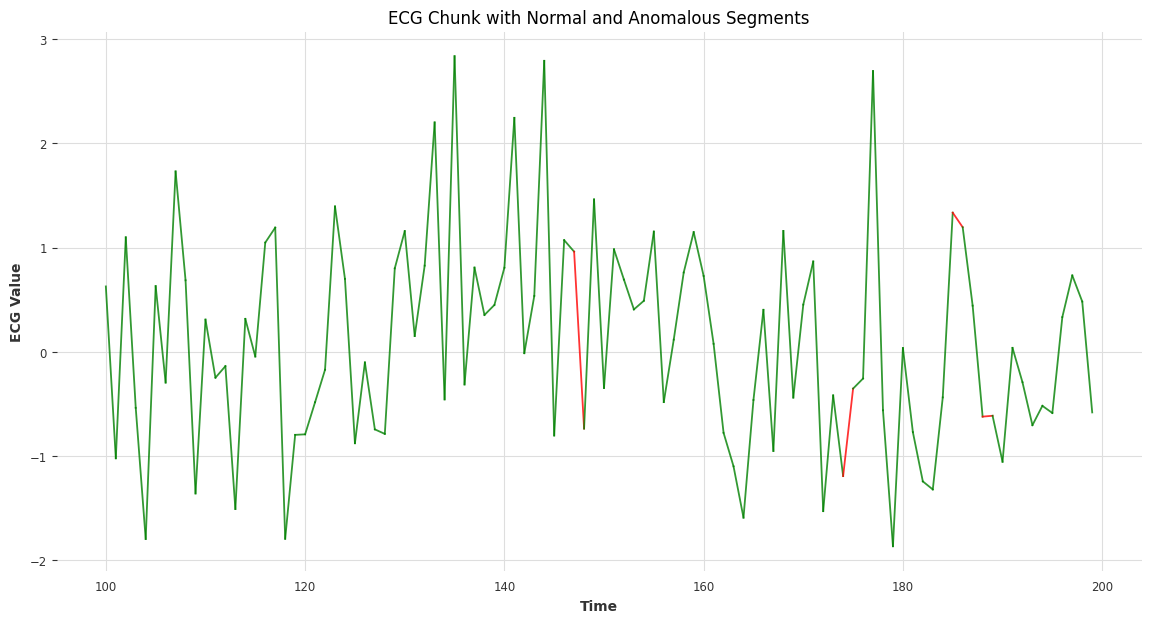

In [63]:
plt.figure(figsize=(14, 7))
for i in range(len(chunk_time_index) - 1):
    plt.plot(chunk_time_index[i:i+2], chunk_ecg_data[i:i+2], color='red' if chunk_anomalies[i] else 'green', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ECG Value')
plt.title('ECG Chunk with Normal and Anomalous Segments')
plt.show()